In [264]:
import os
import sys
import time
from tqdm.notebook import tqdm
import itertools
from collections import Counter

import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [265]:
SEED = 42
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [266]:
data = pd.read_table('./raw_data/data.txt', header=None)
test_ids = pd.read_table('./raw_data/test.txt', header=None)[0].values
data.columns = ['id', 'text']

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  


In [61]:
# Загружаем train.txt
train_df = {'id': [], 'text': [], 'normal': [], 'insult': [], 'obscenity': [], 'threat': []}

with open('./raw_data/train.txt', mode='r', encoding='utf-8') as f:
    for row in tqdm(f, total=148775):
        val = row.split('\t')
        train_df['id'].append(int(val[0]))
        train_df['text'].append(val[-1])
        
        present_labels = [tag for tag in ['normal', 'insult', 'obscenity', 'threat'] if row.lower().find(tag) != -1]
        nonpresent_labels = set(['normal', 'insult', 'obscenity', 'threat']) - set(present_labels)
        for label in present_labels:
            train_df[label].append(1)
        for label in nonpresent_labels:
            train_df[label].append(0)
            
train_df = pd.DataFrame(train_df)
# Сохраняем train_df для дальнейшего обращения к нему
# train_df.to_csv('./processed_data/train_df.csv', index=False)

In [207]:
# Проверяем, что в data есть только индексы из train_df и test_df
set(data['id']) - (set(train_df['id']) | set(test_ids))

set()

In [139]:
tags = ['normal', 'insult', 'obscenity', 'threat']

In [63]:
# train_df = pd.read_csv('./processed_data/train_df.csv')

### EDA

In [126]:
# Проверим корректность сопоставления айдишников в data и в train_df
random_id = train_df['id'].sample().values[0]
print('id:', random_id)
print('-'*100)
print('data["id"]:', data['id'][(data['id'] == random_id)].values[0])
print('data["text"]:', data['text'][(data['id'] == random_id)].values[0])
print('-'*100)
print('train_df["id"]:', train_df['id'][(train_df['id'] == random_id)].values[0])
print('train_df["text"]:', train_df['text'][(train_df['id'] == random_id)].values[0])
print('train_df["labels"]:', np.array(['normal', 'insult', 'obscenity', 'threat'])[np.array(train_df[(train_df['id'] == random_id)].values[0][-4:]).astype(bool)].tolist())


id: 194723
----------------------------------------------------------------------------------------------------
data["id"]: 194723
data["text"]: не надо холодец - растает. не донесу я студень.(вокзал для двоих)
----------------------------------------------------------------------------------------------------
train_df["id"]: 194723
train_df["text"]: не надо холодец - растает. не донесу я студень.(вокзал для двоих)

train_df["labels"]: ['normal']


In [209]:
# Посмотрим на примеры текстов с конкретными метками:
for tag in tags:
    random_id = train_df['id'][(train_df[tag] == 1)].sample().values[0]
    print(f'================={tag}=================')
    print('train_df["id"]:', train_df['id'][(train_df['id'] == random_id)].values[0])
    print('train_df["text"]:', train_df['text'][(train_df['id'] == random_id)].values[0])
    print('train_df["labels"]:', np.array(['normal', 'insult', 'obscenity', 'threat'])
          [np.array(train_df[(train_df['id'] == random_id)].values[0][-4:]).astype(bool)].tolist())
    print('\n'*2)

=================normal=================
train_df["id"]: 240048
train_df["text"]: може трохи дефа поставити ?

train_df["labels"]: ['normal']



=================insult=================
train_df["id"]: 139935
train_df["text"]: так и будут дети гибнут от пьяных сволочей! то бьют, то насилуют... пока не вернут смертную казнь так все и будет продолжаться! будут,суки, рожать и пропивать детские деньги. будут плодить нищету ! что он ,бедный, видел за свою коротенькие жизнь??? голод, холод и побои!!! так и застыл, бедный, со слезами на глазах! твари, мрази! ненавижу вас и признаю! и правительству спасибо за самый гуманный суд в мире и наши законы!!!!

train_df["labels"]: ['insult']



=================obscenity=================
train_df["id"]: 97629
train_df["text"]: сосёт видать однако хорошо👍

train_df["labels"]: ['obscenity']



=================threat=================
train_df["id"]: 237394
train_df["text"]: ужас!!! сволочи, людьми назвать язык не поворачивается! привязать тварей покрепч

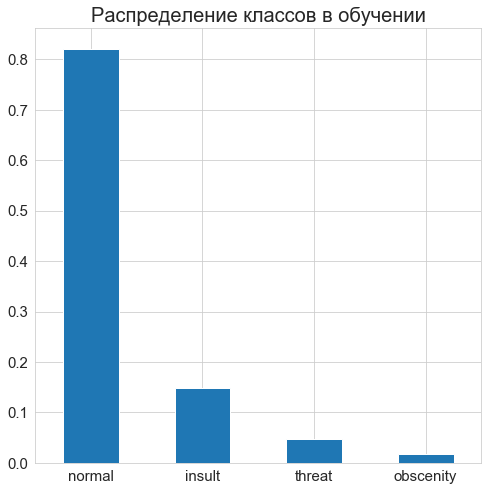

In [270]:
# Распределение классов в обучении
plt.title(f'Распределение классов в обучении', fontsize=20);
train_df[tags].mean().sort_values(ascending=False).plot(kind='bar', fontsize=15);
plt.tick_params(axis='x', rotation=0)

### Разбиение на обучение и валидацию

In [271]:
from sklearn.model_selection import train_test_split

tr_df, val_df = train_test_split(train_df, test_size=0.3, shuffle=True, random_state=SEED)

tr_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
# tr_df.shape[0] / (train_df.shape[0]), val_df.shape[0] / (train_df.shape[0])

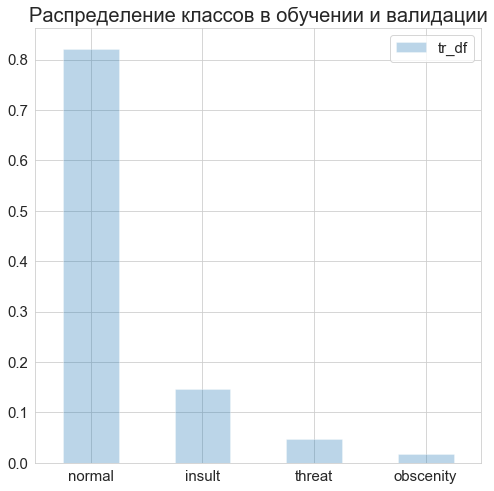

In [274]:
# Распределение классов в обучении
plt.title(f'Распределение классов в обучении и валидации', fontsize=20);
tr_df[tags].mean().sort_values(ascending=False).plot(kind='bar', fontsize=15, alpha=0.3, label='tr_df');
val_df[tags].mean().sort_values(ascending=False).plot(kind='bar', fontsize=15, color='red', alpha=0.3, label='val_df');
plt.legend(fontsize=15);
plt.tick_params(axis='x', rotation=0)

In [275]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### Модели

In [292]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, average_precision_score

#### Tf-idf + logreg

In [293]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [294]:
tf_idf = TfidfVectorizer(analyzer='word', min_df=1, max_df=1.0)
tf_idf.fit(tr_df['text'])

X_tr = tf_idf.transform(tr_df['text'])
X_val = tf_idf.transform(val_df['text'])

In [302]:
from sklearn.linear_model import LogisticRegression

In [304]:
models_dict = {}
for tag in tqdm(tags):
    model = LogisticRegression(C=1.0)
    model.fit(X_tr, tr_df[tag])
    models_dict[tag] = model

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [316]:
print(f"""Обучение: {round(average_precision_score(
    y_true=tr_df[tags].values,
    y_score=np.hstack([models_dict[tag].predict_proba(X_tr)[:, 1].reshape(-1, 1) for tag in tags]),
    average='macro'
), 4)}""")
print(f"""Валидация: {round(average_precision_score(
    y_true=val_df[tags].values,
    y_score=np.hstack([models_dict[tag].predict_proba(X_val)[:, 1].reshape(-1, 1) for tag in tags]),
    average='macro'
), 4)}""")

Обучение: 0.9172
Валидация: 0.8453


In [318]:
a = np.array([200, 100, 50, 300, 400])
print(np.sort(a))
print(np.argsort(a))

[ 50 100 200 300 400]
[2 1 0 3 4]
